<h3>"Call a daggum timeout!"</h3>

-Roy Williams, probably never

Basketball fans generally believe that calling timeouts can slow or stop scoring runs. Certain coaches (famously, Roy Williams) are often criticized for not calling timeouts in an attempt to end a run. However, to the best of my knowledge, this general wisdom has never been tested nor supported by any actual analysis. I intend to use a large dataset (all of the play-by-play data available from ESPN) and some straightforward statistical analysis to show that calling timeouts midgame to end scoring runs has minimal effect on stopping scoring runs.

Scoring runs are expected in any contest just by chance. This can easily be seen from simple coin flips. If a team is expected to convert 50% of their possessions (equivalent to a coin flip), then they can be expected to convert several in a row while the other team converts none. In this way, scoring runs should occur in most basketball contests. In the same way, these scoring runs should be expected to follow similar probability distributions for when they end. That is, after a scoring run starts, it should have a predictable probability of ending due to the same probabilities. I am going to show that calling a timeout either does not speed up the rate at which a run ends or even negatively increases the length of the run (both teams get to use the timeout, why wouldn't the running team also be able to rest and improve their strategy?).

In other words, I believe that far too much emphasis is placed on "momentum", and players should be expected to recognize these "slumps" and "streaks" as statistically probable events; that is, these scoring streaks and slumps should be expected to regress to the mean over time and end naturally. I believe timeouts have no effect on the ability of a team to recover from such a streak or slump. 

Another factor in real basketball games that needs to be considered is the fact that basketball has very frequent time stoppages. In this analysis, stoppages other than timeouts will not be included as causes for "settling" a run, but it stands to reason that timeouts become even less necessary when other time stoppages are considered, as the break in play provides time for quick communication from a coach, substitution of players for tired/injured/otherwise hindered players or better match ups, and, more importantly, settling "frazzled" players, which is the most common justification for this strategy. In future works, I'd like to explore whether this conjecture about the positive effects of other stoppages in play is true.

Additionally, I believe that experience with these events, i.e., "playing through" a cold streak or weathering runs towards the ends of games, results in increased overall win percentage and, in particular, post-season success. In the future, I'd also like to perform a similar analysis on games presumably lost due to running out of timeouts. <a href="https://youtu.be/7HhZBaCAa80?t=702">Here's a nice example.</a>

<b>Disclaimer: This is all an exercise in probability and data scraping. I do believe that there are mental components to athletic contests, and scoring is not independent of these factors. However, I think that a coach could easily coach their team to not expect or wait for timeouts in the case of runs, and it would not have a negative effect on their performance.</b>

Now, to perform this analysis, we need to identify the beginnings and ends of runs. Obviously, there is no objective "best" way to decide these properties, so I attempted to write all of the analysis with a great deal of flexibility and across ranges of values. I made best guesses using values that I considered justifiable. These values are used to find sequences of events that have characteristics we've identified as runs. Using the runs we find and Bayes' Theorem, we'll show that calling timeouts does not stop runs and likely has a negative effect on the ending of a run.

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is hiddenby default for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>. 
Some of the analysis may be a bit disjoint without the comments in the code. If you are
comfortable reading Python, consider viewing the code.''')

In [2]:
# First, we need to import modules and load some dictionaries. 
# The data were scrapped from ESPN's play-by-play reports for each game.
# The webscraping code is available on github/comma3. The dictionaries contain 
# relationships between team names, team abbreviations and ESPN's internal
# codes for each team.

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import sqlite3

# Number of events to include minus (i.e., the diff length 3-1 is 2 but includes 3 events) 
event_length = 2
# Length after run for it to end
event_horizon = 10
# Average margin for a game that prevents blowouts from being counted
max_average_margin = 10

def read_dictionary(filename):
    """
    Opens the indicated filename and creates a list line by line using the first entry on each line
    as the key and the second as the value
    """
    dictionaryoutput = {}
    with open(filename) as file:
        entries = csv.reader(file)
        for item in entries:
            dictionaryoutput[item[0]] = item[1]
    return dictionaryoutput

def write_dict(outputfilename, dictionary):
    """
    Writes a dictionary to a csv.
    """
    # May want to modify this code to pickle the key and value and alter the read dictionary to do the same.

    with open(outputfilename, 'w', newline='') as outfile:
        for key, value in dictionary.items():
            outfile.write('%s,%s\n' % (key, value))

ABRDict = read_dictionary('C:\\Dropbox\\Dropbox\\HAXz\\CBBTO\\espn_scraper\\ABRdictionary.csv')
NUMDict = read_dictionary('C:\\Dropbox\\Dropbox\\HAXz\\CBBTO\\espn_scraper\\NUMdictionary.csv')


The play-by-play data were scrapped from ESPN's play-by-play reports for each game (e.g., http://www.espn.com/mens-college-basketball/playbyplay?gameId=400872229) and are stored in a database. We are only considering scoring events and timeouts, and we exclude a list of games due to errors in the source data. There are a number of cases that make the data unusable. In some cases, scores were only added to one team, resulting in games with final scores of, for example, 163-0. Game events were occasionally duplicated, out of order, or given the same time stamp for several consecutive events. The discovery of these games is discussed below. Bad games are removed completely as the entire set is unreliable.

The cells below show examples of the data and descriptions of the data table.

In [3]:
conn = sqlite3.connect('C:\\Dropbox\\Dropbox\\HAXz\\CBBTO\\data\\CBBdb.sqlite3')
curr = conn.cursor()

# Exclude unused events and corrupted data
data = pd.read_sql_query("""SELECT rowid,*
                        FROM playbyplay
                        WHERE LOWER(event) not like '%free throw%'
                        AND (LOWER(event) like '% made %' OR LOWER(event) like '% timeout%')                       
                        AND game_id not in ('253240066', '253510006', '260692440', '283190221',
                        '283192166', '283190201', '293170264', '283342390', '293172633', 303172239, 290450275,
                        280472483, 283472390, 290450275, 290650087, 293170041, 260280218, 263240150, 270170222,
                        400498526, 400591228, 273332603, 310630171)""", conn)

# We imported the entire DB for debugging and obtained final game scores from it out of conenvience 
all_data = pd.read_sql_query("""SELECT rowid, *
                        FROM playbyplay""", conn)

conn.close()

# Ensure that numbers are numeric values and not strings.
data = data.apply(pd.to_numeric,errors='ignore')
all_data = all_data.apply(pd.to_numeric,errors='ignore')

In [4]:
# Preview the data to esnure that everything was imported correctly
data.head(2)

,rowid,game_id,date,event_index,time,actor,event,away,home,away_score,home_score
0,2,253120183,2005-11-09,1,1176,183,Louie McCroskey made Three Point Jumper.,BCU,SYR,0,3
1,5,253120183,2005-11-09,4,1146,183,Demetris Nichols made Three Point Jumper.,BCU,SYR,0,6


In [5]:
# Check that these values make sense
data.describe()

,rowid,game_id,event_index,time,actor,away_score,home_score
count,3.454050e+05,3.454050e+05,345405.000000,345405.000000,345405.000000,345405.000000,345405.000000
mean,8.209252e+05,3.001511e+08,153.149361,579.708994,887.625477,33.076423,37.678534
std,4.938002e+05,3.830126e+07,93.109853,343.982406,1062.172995,20.626641,22.892175
min,2.000000e+00,2.531202e+08,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,3.907370e+05,2.734203e+08,73.000000,272.000000,127.000000,16.000000,18.000000
50%,7.928930e+05,2.932424e+08,151.000000,578.000000,238.000000,32.000000,36.000000
75%,1.250788e+06,3.102902e+08,226.000000,886.000000,2250.000000,49.000000,55.000000
max,1.704480e+06,4.008704e+08,642.000000,1200.000000,3106.000000,123.000000,143.000000


In [6]:
# We need to divide games into periods so that we don't span halftime,
# overtime periods or different games. Separating games into periods ensures
# that clock behavior is consistent and that score differentials are not
# calculated across periods or games.

# Add each half/ot to periods list
periods = []
lastindex = 0
lasttime = data.iloc[0]['time']
for i, row in data.iterrows():   
    time = row['time']     
    if time > lasttime:
        period = data[lastindex:i]
        period['game_id'].values[0]
        periods.append(data[lastindex:i])
        lastindex = i
    lasttime = time
    
#Add the last period
periods.append(data[lastindex:i])

<h3>How do we find runs?</h3>

First, we record the change in the score margin ($\Delta scoremargin$) between the two teams. We are interested in scoring runs, which we will identify as increases in the absolute value of $\Delta scoremargin$ (that is, one team is scoring more points than the other and increasing/decreasing the score margin).

We exclude the ends of periods because timeout usage and general clock management change dramatically towards the ends of games. As mentioned previously, I would like to explore this time period in the future, as one of the proposed strategic elements of timeouts is preserving them for the ends of games.

Then, we record the score difference between the two teams (not the change in score difference, i.e., not $\Delta scoremargin$, but simply the margin in the score $scoremargin$). A positive value indicates that the home team is winning.

Now, we find $\Delta scoremargin$ by calculating the difference between the score margins at two different times. As discussed above, each event is either a made basket or a timeout. In this work, we calculate the difference in margin across three events because we are using $\Delta scoremargin >= 6$ across three events (timeouts and made baskets) as our criteria for a run. Including timeouts reduces the number of events identified as runs, as in principle, the timeout should reduce the likelihood of a run starting. That is, sequences like $home score$, $timeout$, $home score$, $home score$ won't be identified as runs, even when they probably should be (and in particular a run not stopped by a timeout, which is the figure I believe to be much higher than fans generally believe).

Based on manual inspection, the sequences identified by this algorithm tend to "feel" like runs (i.e., situations where fans start screaming for TOs). 

To give example numbers for this analysis, if a game begins with a score of 0-0, the $score margin$ is zero. Three "events" later, the score is 3-4 (one 3pt and two 2pts) and the $score margin$ is -1 $(3 - 4 = -1)$. Thus, the change in the score difference ($\Delta scoremargin$) is -1 $(-1 - 0 = -1)$. Then, three more events later, the score is 3-10. The score difference is -7 $(3 - 10 = -7)$ and $\Delta scoremargin$ is -6 $(-7 - (-1) = -6)$. That is, the difference in score has increased by -6 (negative indicates away team). This value, $|\Delta scoremargin|$ >= 6, represents the minimum criteria for a run to start. The analysis gives the same absolute value if the scores were reversed (i.e., the home team went on the run).

Note that free throws are not included as events in this analysis, but the points are included. That is, free throws can prevent the start of a scoring run even if a team makes no field goals. For example, if a team scores 3 consecutive baskets, but fouls on every possession at the other end, $|\Delta scoremargin|$ could be less than 6, and we do not consider this sequence of events to represent a scoring run. Alternatively, a team may not need three consecutive baskets to start a scoring run. For example, two 3pts and an opposing 2pt could start a run if the opposing team also fouled in that time frame.

In [7]:
score_margin_dict = {}
for i,period in enumerate(periods):
    # Drop ends of periods because strategy can change
    period = period.loc[period['time'] > 90]
    
    # Current score margin
    # Will be used with diff below to calculate change in score difference
    period['delta_score_margin'] = period['home_score'] - period['away_score']
        
    average_score_margin = period['delta_score_margin'].mean()
    #score_margin_list.append(average_score_margin)
    score_margin_dict[period['game_id'].values[0]] = average_score_margin



c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
# Calculating the quantities described above.

# List that holds the differences from each period
differences = []

# The following list and dictionary are used to calculate the average score margin.
# Based on the above analysis, we only want to analyze games that were
# competitive because scoring streaks are very common in games where
# teams are not comptetitive and it is highly likely that a much better team will
# continue to score at a much faster rate. I don't want these situations to strengthen
# my claims.

# We use a dictionary so we can identify game-by-game avarage score margins.
# key : game_id, value : average score margin
score_margin_dict = {}

# The list is only used to investigate the data to find bad games
score_margin_list = []

# We could eliminate games based on average score margins here to speed up the analysis
# but I'm leaving all of the data in the analysis as long as possible in case the
# approach needs to change or the specific cutoff criteria change.
for period in periods:
    # Drop ends of periods because strategy can change
    period = period.loc[period['time'] > 90]
    
    # Current score margin
    # Will be used with diff below to calculate change in score difference
    period['delta_score_margin'] = period['home_score'] - period['away_score']

    average_score_margin = period['delta_score_margin'].mean()
    score_margin_list.append(average_score_margin)
    score_margin_dict[period['game_id'].values[0]] = average_score_margin
  
    # Get delta time and delta score marging
    difference = period[['time','delta_score_margin']].diff(event_length)
    
    # Pass data forward - need to copy from the undiffed data frame
    difference['row_id'] = period['rowid']
    difference['game_id'] = period['game_id']
    difference['event'] = period['event']
    difference['actor'] = period['actor']
    difference['home'] = period['home']
    difference['away'] = period['away']
    difference['home_score'] = period['home_score']
    difference['away_score'] = period['away_score']
    difference['score_margin'] = period['home_score'] - period['away_score']
    
    # Passage of time (delta_time) should be positive but difference is calculated from a counting down clock.
    difference['delta_time'] = -difference['time']
    difference['time'] = period['time']
    
    # Because we are using diff, the first few rows of a period cannot be calculated because there is no
    # appropriate value. Pandas gives not a numbers for these cases,
    # and we can drop these entries as meaningless.
    difference = difference[['game_id','row_id','event','actor','home','away','home_score', 'away_score','score_margin','time','delta_time','delta_score_margin']].dropna()
    differences.append(difference)

# We can combine all of these values into one dataframe again because we no longer have to worry about overlapping adjacent events 
result = pd.concat(differences)

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now, we examine our data to make sure it all makes sense. I've already excluded many games (see the above list in the SQL query) because they were found to have corrupted data.

You may safely ignore all of these tables and plots if you aren't interested in the code or data cleaning.

In [9]:
# Checking for infinite values
result.loc[(result.delta_score_margin == np.inf) | (result.delta_score_margin == np.inf)]

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin


In [10]:
# We start with the average score margin, which we will use later to eliminate uncompetitive games
score_margin_df = pd.DataFrame({'scores':score_margin_list})
score_margin_df.describe()

,scores
count,11247.000000
mean,4.246515
std,10.635368
min,-37.760870
25%,-2.111111
50%,3.000000
75%,9.400000
max,67.729730


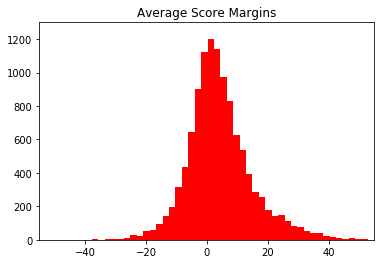

In [11]:
# Everything looks pretty expected here. 
# As will be common and is expected, there is a slight skew toward the home team.
fig = plt.figure()
plt.ylim([0,1300])
plt.xlim([-55,55])
plt.hist(score_margin_df.scores, bins=50, color='r', alpha=1, label='diff')
plt.title("Average Score Margins")
plt.show()

In [12]:
# On to the analysis data
# No negative scores or times, obscenely high scores or margins (well, 70 is obscene but it's real)
# No unrealistic times, and medians all look close to expected values.
result.describe()

,game_id,row_id,actor,home_score,away_score,score_margin,time,delta_time,delta_score_margin
count,2.926490e+05,2.926490e+05,292649.000000,292649.000000,292649.000000,292649.000000,292649.000000,292649.000000,292649.000000
mean,3.001159e+08,8.203807e+05,888.742688,37.054301,32.321149,4.733151,595.044610,73.767014,0.250191
std,3.829253e+07,4.935350e+05,1062.754609,22.020728,19.564871,11.921636,293.569413,41.233040,2.681713
min,2.531202e+08,6.000000e+00,-1.000000,0.000000,0.000000,-53.000000,91.000000,-0.000000,-13.000000
25%,2.734203e+08,3.907590e+05,127.000000,18.000000,15.000000,-3.000000,340.000000,44.000000,-2.000000
50%,2.932402e+08,7.921880e+05,238.000000,36.000000,31.000000,3.000000,596.000000,65.000000,0.000000
75%,3.102902e+08,1.249494e+06,2250.000000,54.000000,47.000000,11.000000,855.000000,95.000000,2.000000
max,4.008704e+08,1.704465e+06,3106.000000,141.000000,120.000000,83.000000,1190.000000,538.000000,12.000000


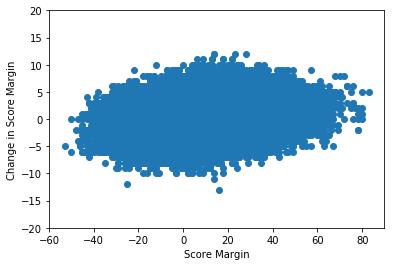

In [13]:
# We scatter plot score_margin and delta_score_margin so we can look at both quantities at once

plt.scatter(result['score_margin'],result['delta_score_margin'])
plt.ylim([-20,20])
plt.xlabel('Score Margin')
plt.ylabel('Change in Score Margin')
plt.show()

In [14]:
# We manually investigate the games 
result.loc[(result['delta_score_margin'] < -11)]

# We can use the code in the next cell to look at specific games 
# all_data.loc[(all_data.game_id == 253130183)]
# or the link
# http://www.espn.com/mens-college-basketball/playbyplay?gameId=400872229
# substituting in the game_id

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin
65242,270450213,296604,Ron Lewis made Three Point Jumper.,194,PSU,OSU,14,39,-25,136,220.0,-12.0
112419,280512633,507325,Quantez Robertson made Three Point Jumper.,2,TENN,AUB,83,67,16,159,136.0,-13.0


In [85]:
runs.loc[(runs.index < 6990)&(runs.index > 5830)] 

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin
5835,253370127,27046,Paul Davis made Two Point Jumper. Assisted by...,127,MSU,UALR,39,32,7,1044,125.0,7.0
6394,253390356,29527,Warren Carter made Two Point Jumper. Assisted...,356,ILL,UALR,11,6,5,836,120.0,7.0
6435,253390356,29719,Shaun Pruitt made Two Point Layup.,356,ILL,UALR,60,39,21,410,65.0,7.0
6558,253402083,30361,Allan Ray made Three Point Jumper.,222,BUCK,NOVA,48,62,-14,566,48.0,-7.0
6559,253402083,30363,Kyle Lowry made Two Point Layup. Assisted by ...,222,BUCK,NOVA,48,64,-16,548,49.0,-7.0
6585,253400127,30472,Jared Dudley made Two Point Jumper. Assisted ...,103,MSU,BC,9,12,-3,806,102.0,-7.0
6599,253400127,30544,Jared Dudley made Two Point Tip Shot.,103,MSU,BC,23,27,-4,103,67.0,-7.0
6644,253402507,30732,Lee Humphrey made Three Point Jumper. Assiste...,57,PROV,FLA,0,9,-9,934,163.0,-7.0
6661,253402507,30773,Lee Humphrey made Three Point Jumper.,57,PROV,FLA,14,29,-15,527,45.0,-7.0
6805,253400282,31423,Jay Tunnell made Two Point Jumper. Assisted b...,282,INST,IND,37,41,-4,996,108.0,7.0


In [78]:
all_data.loc[(all_data.rowid < 27055)&(all_data.rowid > 27035)] 

,rowid,game_id,date,event_index,time,actor,event,away,home,away_score,home_score
27035,27036,253370127,2005-12-03,129,1176,2031,Rashad Jones-Jennings made Free Throw.,UALR,MSU,31,30
27036,27037,253370127,2005-12-03,130,1176,2031,Rashad Jones-Jennings made Free Throw.,UALR,MSU,32,30
27037,27038,253370127,2005-12-03,131,1169,127,Paul Davis made Two Point Jumper.,UALR,MSU,32,32
27038,27039,253370127,2005-12-03,132,1169,2031,Foul on Zack Wright,UALR,MSU,32,32
27039,27040,253370127,2005-12-03,133,1169,127,Paul Davis made Free Throw.,UALR,MSU,32,33
27040,27041,253370127,2005-12-03,134,1145,2031,Foul on Lekheythan Malone,UALR,MSU,32,33
27041,27042,253370127,2005-12-03,135,1145,127,Paul Davis made Free Throw.,UALR,MSU,32,34
27042,27043,253370127,2005-12-03,136,1145,127,Paul Davis made Free Throw.,UALR,MSU,32,35
27043,27044,253370127,2005-12-03,137,1111,127,Paul Davis made Two Point Jumper.,UALR,MSU,32,37
27044,27045,253370127,2005-12-03,138,1075,127,Foul on Drew Neitzel,UALR,MSU,32,37


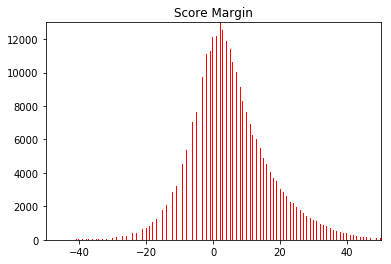

In [16]:
# We also use histograms to check if there is anything wrong with the shape.
fig = plt.figure()
plt.ylim([0,13000])
plt.xlim([-50,50])
plt.hist(result['score_margin'], bins=500, color='r', alpha=1, label='diff')
plt.title("Score Margin")
plt.show()

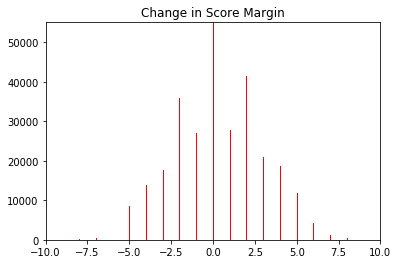

In [17]:
fig = plt.figure()
plt.ylim([0,55000])
plt.xlim([-10,10])
plt.hist(result['delta_score_margin'], bins=500, color='r', alpha=1, label='diff')
plt.title("Change in Score Margin")
plt.show()

# 1pt score differentials are slightly depressed as expected

In [18]:
# The pd.diff calculation above can be somewhat slow, so we can save/load the results here to speed up analysis.

result.to_csv('run_calculation_diff2.csv', encoding='utf-8')
write_dict('score_margin_dictionary.csv', score_margin_dict)

#score_margin_dict = read_dictionary('score_margin_dictionary.csv')
#result = pd.read_csv('run_calculation_diff3.csv', header = 0)

In [19]:
result.head(2)

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin
2,253120183,6,Sam Barber made Two Point Jumper.,2065,SYR,BCU,6,2,4,1125,51.0,1.0
3,253120183,7,Antonio Webb made Three Point Jumper.,2065,SYR,BCU,6,5,1,1105,41.0,-5.0


In [20]:
# Now, we collect the situations that qualify as runs based on our previous discussion.
runs = result.loc[(result.delta_score_margin > 6) | (result.delta_score_margin < -6)]

In [21]:
runs.head(2)

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin
16,253120183,90,Gerry McNamara made Three Point Jumper.,183,SYR,BCU,25,10,15,307,199.0,7.0
478,253182294,2252,Alex Thompson made Two Point Dunk Shot. Assis...,2294,IOWA,UMES,80,33,47,329,75.0,8.0


In [22]:
runs.describe()

,game_id,row_id,actor,home_score,away_score,score_margin,time,delta_time,delta_score_margin
count,2.396000e+03,2.396000e+03,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,3.020209e+08,8.441066e+05,822.924875,41.277546,32.844741,8.432805,549.890234,120.505843,2.700334
std,3.989112e+07,4.975660e+05,1031.145424,22.923513,19.502264,14.627885,281.572254,46.358875,6.925878
min,2.531202e+08,9.000000e+01,-1.000000,0.000000,0.000000,-42.000000,91.000000,12.000000,-13.000000
25%,2.735503e+08,4.074572e+05,127.000000,22.000000,16.000000,-1.000000,300.000000,88.000000,-7.000000
50%,2.934663e+08,8.448485e+05,229.500000,40.000000,32.000000,8.000000,523.500000,114.000000,7.000000
75%,3.104001e+08,1.273436e+06,2181.000000,59.000000,48.000000,17.000000,779.000000,145.000000,7.000000
max,4.008704e+08,1.704069e+06,2934.000000,134.000000,91.000000,72.000000,1117.000000,456.000000,12.000000


<h3>How do we identify the end of a run?</h3> 

Does a single basket end a run? That seems a bit generous to me.

Does the team that's "slipping" need to make a complete comeback? That seems like a really difficult requirement to satisfy.

I think the natural minimum requirement is returning to trading baskets (i.e., $\Delta scoremargin = 0$) as that's indicative of a perfectly competitive game. Even if the running team still holds a lead (or made a comeback), the damage is at least somewhat mitigated. However, an informal survey I conducted had suggestions of even lower requirements than trading baskets. Therefore, I am going to explore a range of scoring ratios as the ending criterion. Using a ratio also includes the minimum requirement that the slipping team scores at least 1 point as, otherwise, we will produce a divide by zero error (which we just handle as not stopping the run). 

We'll define this critical score ratio as $r = \frac{runner score}{slipper score}$.

A value of the ratio $\frac{runner score}{slipper score} <= 1$ indicates that the slipping team has scored at least as many points as the running team (i.e., trading baskets or better) and is the minimum tested value for ending a run. At the other extreme, the ratio $\frac{runner score}{slipper score} >= 2$ corresponds to the running team scoring points at at least a 2:1 ratio, which indicates that the running team is still very much on a run. I maintain that the 1:1 scoring ratio seems best as a criterion for "ending a run" (if you are continuing to lose by more, how can the run be over?), but we will calculate other values for argument's sake.

In the analysis below, we collect the ten scoring and timeout events after a run is considered to have started. We are only interested in the first few possession after a run and subsequent timeout. If a run doesn't end within ten events after the start of the run, it is effectively considered to have not been stopped; I believe this to be a very generous time horizon for a slipping team to end a run. We aren't interested in extending the time to infinity as strategies can change with large leads and near the ends of games and nearly all runs will "end" when sufficiently large margins are achieved. Furthermore, the probability of two timeouts goes to infinity quite quickly thanks to TV timeouts.

As presented above, runs are considered to end when the score ratio $\frac{runner score}{slipper score} <=r$, i.e., the indicated ratio from 1 to 2, or two timeouts are called (as the first timeout is deemed inadequate to stop a run). We can also differentiate these scenarios based on the type of timeout (runner called, slipper called, or official/TV).

From this information, we are going to calculate certain probabilities:

1) The overall probability that a run ended (and its inverse that a run did not end).

2) The probability that a timeout was called and the run ended.

3) The probability that a timeout was called and the run did not end.

From these probabilities and Bayes' Theorem, we can calculate the probability that the timeout was responsible for the run ending. In other words, would a run have stopped without the timeout? Frequentist statistics can also be directly observed.

In [91]:
# This value comes from the diff function above.
diff_length = event_length



# The result is a list. We are going to store the results as 2-d array [[run stop criteria, results]]
different_stop_criteria = []
# Choosing the correct criteria for a run stop is difficult, so I'll go ahead and
# calculate a range so you can argue about it.
run_criteria = [1 + x/10 for x in range(11)]

for run_criterion in run_criteria:
    run_stops = []
    indx = 0 # index of last run event
    for i,row in runs.iterrows():
        # If rows in run belong to the same run, we group them and skip ahead
        # We don't want to double count anything.
        # This code finds the index of an event in result, which is continuous for every
        # event of interest, and then checks if the index of the next event in runs differs by 1,
        # which means they are from the same run.
        if result.loc[result.row_id == row['row_id']].index[0] <= indx + 1:
            indx += 1 
            continue
            
        # We use the index from the original dataset to find the events
        indx = result.loc[result.row_id == row['row_id']].index[0]

        # Grab a few extra events - if a run doesn't end after 10 events or 2 timeouts, it's considered to not end
        working = result.loc[(result.index >= indx - diff_length) & (result.index <= indx + event_horizon)]
        # Reset the index for the slice
        working = working.reset_index()
        del working['index']

        # Collect some values
        run_start_time = row['time']

        team_list = [data.loc[(data.rowid == row['row_id'])]['home'].values[0], data.loc[(data.rowid == row['row_id'])]['away'].values[0]]
        # Positive delta_score_margins indicate home team is on the run, which is index zero in team_list
        runner_index = 0 if row['delta_score_margin'] > 0 else 1
        # We can the runner name here
        runner = team_list[runner_index]
        # Set to false to start, changed to true if any of our run end criteria are met 
        run_ended = False
        
        # Use this value to set the recovery start to the index of the timeout
        timeout_index = 0
        
        timeouts = []
        score_log = []
        last_time = 1200
        for j,event in working.iterrows():
            # Need to guarntee that we collect these values, which is the score when the run starts
            if j == diff_length:
                run_start_scores = to_start_scores = [event['home_score'], event['away_score']]

            # Triggered if run starts at the beginning of a half
            # Continues on normally after j >= diff_length so no problems skipping ahead
            if run_start_time > event['time'] and j < diff_length:
                continue

            # Or if the slice crosses ahead into a new period or game, we end the run
            # We exclude these events below as being too close to the ends of games to analyze properly
            # New period
            if last_time - event['time'] < 0:
                timeouts.append([j, 'End Game', '', ''])
                break
            last_time = event['time']
            # New game - should get caught above but just in case something else goes wrong
            if event['home'] not in team_list:
                timeouts.append([j, 'End Game', '', ''])
                print('error')
                break

            if 'timeout' in event['event'].lower():
                # If we get a second stop in play after the run starts, we are going to consider the run not stopped
                attempt_stop = 0
                # We are only counting timeouts that are called after the run stops
                # but this could be up for debate
                if j > diff_length:
                    attempt_stop += 1
                if timeouts:
                    for timeout in timeouts:
                        if timeout[0] > diff_length:  # We don't want to stop the run for TOs during the build up
                            attempt_stop += 1
                            # We replace the initial starting score that is used to stop a run
                            # with the score when the timeout is called
                            to_start_scores = [event['home_score'], event['away_score']]
                            timeout_index = j
                
                # Check if timeout caller is winning
                # There are a few examples where espn gave -1
                # will need to address this later
                try:
                    caller = NUMDict[str(event['actor'])]
                except:
                    caller = 'error'
                # ESPN doesn't use a separate code for official TOs, instead just using one of the teams
                # We manually override this flaw.
                if ' tv ' in event['event'].lower():
                    caller = 'tv'
                # Identify currently winning team
                is_winning = caller == ABRDict[team_list[0] if event['home_score'] - event['away_score']  >= 0 else team_list[1]]
                # Check if the TO caller is the team that is running
                is_running = caller == ABRDict[runner] # tv == False
                timeouts.append([j, caller, is_winning, is_running, [event['home_score'], event['away_score']]])
                # If we have two TOs during a run, we are going to consider it not stopped
                if attempt_stop >= 2: 
                    break
                # No scoring occurred so we don't need to finish the loop (prevent duplicates from being added to score_log)
                continue 
            else:
                score_log.append([j,[event['home_score'],event['away_score']]])
            
            # Convince myself that these lists aren't the same list
            # print(to_start_scores is run_start_scores)
            
            # Now we check if the slipping team has satisfied the scoring requirement
            # We need at least 4 events after the run started otherwise a single basket by the
            # slipping team would end the run. This will check all events up to event_horizon 
            if j > diff_length + 4 and len(score_log) > 2: # Check the length of the score log just in case there wasn't two scores
                # (0 - 1 = -1 == 1 in two item list)
                # Calculate the score margin between current score (score_log[-1] is last added score, [1] is the second entry
                # which contains the scores, and [runner_index] sets the appropriate index)
                slipper_score_margin = score_log[-1][1][runner_index-1] - run_start_scores[runner_index-1]
                runner_score_margin = score_log[-1][1][runner_index] - run_start_scores[runner_index]
                to_slipper_score_margin = score_log[-1][1][runner_index-1] - to_start_scores[runner_index-1]
                to_runner_score_margin = score_log[-1][1][runner_index] - to_start_scores[runner_index]
                try:
                    if runner_score_margin / slipper_score_margin <= run_criterion:
                        run_ended = True
                        break
                    # We also check from the point where a timeout was called
                    # We need to offset the start of checking this quantity by timeout_index
                    # to ensure that we account for at least 4 events otherwise we risk ending a run for a single field goal
                    # If there is no timeout, this conditional simplifies to the one above
                    # with to_start_scores == 
                    if to_runner_score_margin / to_slipper_score_margin <= run_criterion and j > diff_length + timeout_index + 4:
                        run_ended = True
                        break
                except:
                    # If the slipper hasn't scored we'll get div by zero, but we don't care so we move on
                    pass

        # Get final score - not really used here but might be in the future
        final = all_data.loc[(all_data.game_id == row.game_id)].tail(1)
        final_scores = [final['home_score'].values[0], final['away_score'].values[0]]
        # Use final score to determine the index of the winning team
        winner = team_list[0 if (final['home_score'].values > final['away_score'].values) else 1]
        run_stops.append([event.game_id, team_list, winner, runner, run_ended, timeouts, score_log, final_scores])
        
    different_stop_criteria.append([run_criterion, run_stops])



Now we have the probabilities that we need to use Bayes' Theorem to determine the probability that a timeout has an effect on a scoring run. A very good explanation that can help with intuitive understanding can be found at <a href = 'https://betterexplained.com/articles/an-intuitive-and-short-explanation-of-bayes-theorem/'>betterexplained.com</a>. The equation follows:

$$P(Run Ended | Timeout Called) = \frac{P(Timeout Called | Run Ended)P(Run Ended)}{P(Timeout Called | Run Ended)P(Run Ended) + P(Timeout Called | Run Not Ended)P(Run Not Ended)}$$

where P(Run Ended | Timeout Called) = probability that calling a timeout is responsible for ending a run,

P(Timeout Called | Run Ended) = probability that a timeout was called and the run ended, 

P(Run Ended) = probability that a run ends at all (based on our criteria),

P(Timeout Called | Run Not Ended) = probability that a timeout was called but the run did not end,

and P(Run Not Ended) = probability that the run did not end.

These individual probabilities as well as the number of examples found in the dataset can be seen below for different score ratios (r).

In [92]:
score_ratio_list = []
bayes_probs = []
slipper_bayes_probs = []
runs_stopped_probs = []
runs_stopped_to_probs = []
slipper_runs_stopped_to_probs = []

for stop in different_stop_criteria:
    score_ratio = stop[0]
    run_stops = stop[1]
    
    total_rows = len(run_stops)
    
    # We want to differentiate who called the timeout
    # I thought about using lists or named tuples, but just variables seemed like
    # it would make the code more readable
    run_stopped = 0
    run_not_stopped = 0
    timeout_and_run_stopped = 0
    timeout_and_run_not_stopped = 0
    tv_timeout_and_run_stopped = 0
    tv_timeout_and_run_not_stopped = 0
    runner_timeout_and_run_stopped = 0
    runner_timeout_and_run_not_stopped = 0
    slipper_timeout_and_run_stopped = 0
    slipper_timeout_and_run_not_stopped = 0


    for row in run_stops:
        end_game = False
        
        # Exclude games that aren't competitive
        # This is an average so it shouldn't be too heavily weighted
        # by scoring at the end of the game because we aren't including
        # free throws as events
        if abs(score_margin_dict[row[0]]) > 5: #max_average_margin:
            # Any time we exclude a row, we need to subtract it from our total count
            total_rows -= 1
            continue
        
        # Indicies for row
        # [game_id, team_list, winner, runner, run_ended, timeouts, score_log, final_scores]
        
        # Exclude runs that traverse into end game terroritory
        if row[5]:
            for to in row[5]:
                if to[1] == 'End Game':
                    total_rows -= 1
                    end_game = True
        if end_game:
            continue

        # Run stopped
        if row[4]:
            run_stopped += 1
            # TOs called
            if row[5]:
                # Only identifying 1st timeout for each run
                to_counted = False
                for to in row[5]:
                    # to indices [j, caller, is_winning, is_running, [event['home_score'], event['away_score']]
                    # Make sure the TO we count is after the run started
                    if to[0] > diff_length:
                        if not to_counted:
                            timeout_and_run_stopped += 1
                            to_counted = True
                            if to[1] == 'tv':
                                tv_timeout_and_run_stopped += 1
                            elif not to[3]:
                                slipper_timeout_and_run_stopped += 1
                            elif to[3]:
                                runner_timeout_and_run_stopped += 1

        # Run not stopped
        else:
            run_not_stopped += 1
            if row[5]:
                to_counted = False
                for to in row[5]:
                    if to[0] > diff_length:
                        if not to_counted:
                            timeout_and_run_not_stopped += 1
                            to_counted = True
                            if to[1] == 'tv':
                                tv_timeout_and_run_not_stopped += 1
                            elif not to[3]:
                                slipper_timeout_and_run_not_stopped += 1
                            elif to[3]:
                                runner_timeout_and_run_not_stopped += 1

    # Calculate probabilities
    # Overall probability of a run stopping
    PRS = run_stopped/total_rows
    # Overall probability of run not stopping
    PRNS = run_not_stopped/total_rows
    # Probabiliyt of run stopping when a timeout is called
    PT_RS = timeout_and_run_stopped/(timeout_and_run_stopped + timeout_and_run_not_stopped)
    # Probabiliyt of run not stopping when a timeout is called
    PT_RNS = timeout_and_run_not_stopped/(timeout_and_run_stopped + timeout_and_run_not_stopped)
    
    PTRS_RS = PT_RS * PRS
    PTRNS_TRNS = PT_RNS * PRNS
    
    bayes_prob = (PTRS_RS)/(PTRS_RS + PTRNS_TRNS)
    
    slipper_PT_RS = slipper_timeout_and_run_stopped/(slipper_timeout_and_run_stopped + slipper_timeout_and_run_not_stopped)
    slipper_PT_RNS = slipper_timeout_and_run_not_stopped/(slipper_timeout_and_run_stopped + slipper_timeout_and_run_not_stopped)
    slipper_PTRS_RS = slipper_PT_RS * PRS
    slipper_PTRNS_TRNS = slipper_PT_RNS * PRNS
    slipper_bayes_prob = (slipper_PTRS_RS)/(slipper_PTRS_RS + slipper_PTRNS_TRNS)
    
    
                                
                                
    print('\n+++++++++++++++')                           
    print('Score ratio')
    print(score_ratio)
    print('+++++++++++++++') 
    print('---------------')
    print('Run stopped')
    print('---------------')
    print(run_stopped)
    print('{:.1%}'.format(PRS))
    print('---------------')
    print('Run not stopped')
    print('---------------')
    print(run_not_stopped)
    print('{:.1%}'.format(PRNS))
    print('---------------')
    print('Timeout and run stopped')
    print('---------------')
    print(timeout_and_run_stopped)
    print('{:.1%}'.format(PT_RS))
    print('---------------')
    print('Timeout and run not stopped')
    print('---------------')
    print(timeout_and_run_not_stopped)
    print('{:.1%}'.format(PT_RNS))
    print('---------------')
    print('P(Run Ended|TimeoutCalled)')
    print('---------------')
    print('{:.1%}'.format(bayes_prob))
    
    
    score_ratio_list.append(score_ratio)
    
    runs_stopped_probs.append(PRS)
    
    runs_stopped_to_probs.append(PT_RS)
    slipper_runs_stopped_to_probs.append(slipper_PT_RS)
       
    bayes_probs.append(bayes_prob)
    slipper_bayes_probs.append(slipper_bayes_prob)
        


+++++++++++++++
Score ratio
1.0
+++++++++++++++
---------------
Run stopped
---------------
166
36.4%
---------------
Run not stopped
---------------
290
63.6%
---------------
Timeout and run stopped
---------------
144
33.5%
---------------
Timeout and run not stopped
---------------
286
66.5%
---------------
P(Run Ended|TimeoutCalled)
---------------
22.4%

+++++++++++++++
Score ratio
1.1
+++++++++++++++
---------------
Run stopped
---------------
166
36.4%
---------------
Run not stopped
---------------
290
63.6%
---------------
Timeout and run stopped
---------------
144
33.5%
---------------
Timeout and run not stopped
---------------
286
66.5%
---------------
P(Run Ended|TimeoutCalled)
---------------
22.4%

+++++++++++++++
Score ratio
1.2
+++++++++++++++
---------------
Run stopped
---------------
179
39.3%
---------------
Run not stopped
---------------
277
60.7%
---------------
Timeout and run stopped
---------------
155
36.1%
---------------
Timeout and run not stopped
-----

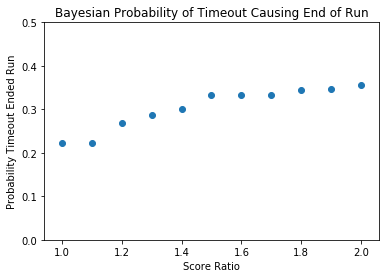

In [93]:
plt.scatter(score_ratio_list, bayes_probs)
plt.ylim([0,0.5])
plt.title('Bayesian Probability of Timeout Causing End of Run')
plt.xlabel('Score Ratio')
plt.ylabel('Probability Timeout Ended Run')
plt.show()

# Plot of Bayesian probabilities that timeouts are responsible for run stops as a function of
# the required score ratio to end a run (runner score/slipper score).

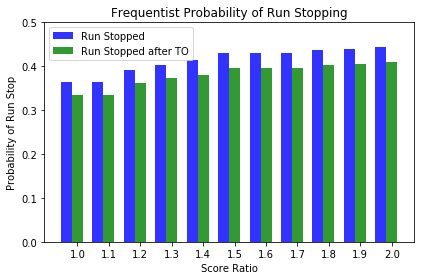

In [94]:
n_groups = 11
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, runs_stopped_probs, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Run Stopped')
 
rects2 = plt.bar(index + bar_width, runs_stopped_to_probs, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Run Stopped after TO')
 
plt.xlabel('Score Ratio')
plt.ylabel('Probability of Run Stop')
plt.title('Frequentist Probability of Run Stopping')
plt.xticks(index + bar_width, ('1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2.0'))
plt.legend()

plt.ylim([0,0.5])
plt.tight_layout()
plt.show()

# Plot showing that for all score ratios, the liklihood of a run stopping decreases when a timeout is called. 

<b>Timeouts help the running team</b>

Our analysis shows that there's as low as a 22% chance that timeouts are responsible for ending runs, with even the extremely generous 2:1 scoring ratio yielding only a 35.6% chance. This behavior likely results from the low prior probability that runs stop at all. 

The frequentist probabilities also show that calling a timeout results in an even lower probability of having a run end, which may be more convincing than the Bayesian analysis. This result seems to suggest that timeouts could even help the running team increase the length and/or intensity of their run. 

One final piece of evidence (that is very convincing if I may say so) is the consideration of the <i>type</i> of timeout. I would contest we should only be looking at situations where the slipping team calls the timeout as TV timeouts are independent of runs, and we would have to question the entire premise of timeouts helping the slipping team if running teams call them frequently to their own detriment.

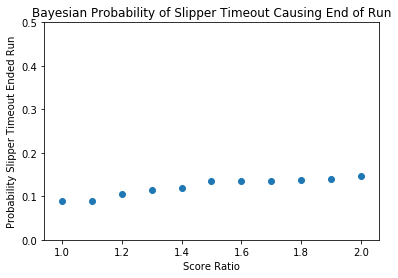

In [95]:
plt.scatter(score_ratio_list, slipper_bayes_probs)
plt.ylim([0,0.5])
plt.title('Bayesian Probability of Slipper Timeout Causing End of Run')
plt.xlabel('Score Ratio')
plt.ylabel('Probability Slipper Timeout Ended Run')
plt.show()

# Plot of Bayesian probabilities that timeouts are responsible for run stops as a function of
# the required score ratio to end a run (runner score/slipper score).

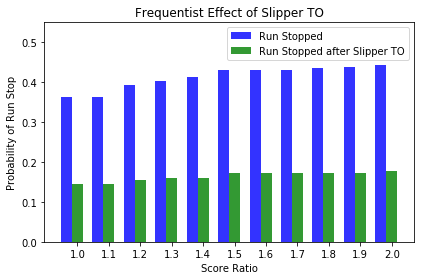

In [96]:
n_groups = 11
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, runs_stopped_probs, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Run Stopped')
 
rects2 = plt.bar(index + bar_width, slipper_runs_stopped_to_probs, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Run Stopped after Slipper TO')
 
plt.xlabel('Score Ratio')
plt.ylabel('Probability of Run Stop')
plt.title('Frequentist Effect of Slipper TO')
plt.xticks(index + bar_width, ('1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2.0'))
plt.legend()

plt.ylim([0.0,0.55])
plt.tight_layout()
plt.show()

# Plot showing that for all score ratios, the liklihood of a run stopping decreases when a timeout is called.

When we exclude runner timeouts and tv timeouts, the probability that timeouts end runs decreases dramatically. This behavior may be related to the previously discussed impact of unequally matched teams. However, we only look at games where the average score margin is less than 5, which is quite restrictive to games that are close throughout or at the very least have significant lead changes. Controlling for the competitiveness of the games lends a great deal of support to the conclusion that timeouts called by teams that are on the bad side of a run don't have the intended effect of ending the run.

Thus, Roy Williams should feel vindicated in his refusal to call these timeouts that apparently have the exact opposite effect that fans and coaches seems to think. Not that he needs it with <a href="http://scout.com/college/north-carolina/Bolt/LOOK-UNCs-2017-National-Championship-Rings-107146391">his rings.</a>

<b> Supporting Info</b>
This figure show that the difference between the probability of a run stopping with and without a TO isn't constant or monotonic, which would indicate some bias in the method.

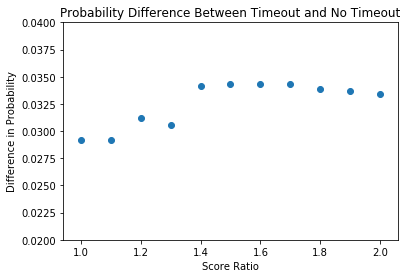

In [97]:
# Want to show that this value isn't constant or monotonic, which would indicate some bias in the method.

probdiff = [x[0] - x[1] for x in zip(runs_stopped_probs, runs_stopped_to_probs)]

plt.scatter(score_ratio_list, probdiff)
plt.ylim([0.02,0.04])
plt.title('Probability Difference Between Timeout and No Timeout')
plt.xlabel('Score Ratio')
plt.ylabel('Difference in Probability')
plt.show()

In [98]:
# Nice little alert to let me know when the Notebook has finished
from IPython.display import HTML
HTML('''<script>
alert('Done!')
</script>''')